Importing the necessary libaries

In [2]:
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

importing the list of the paths

In [3]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

40000


function to plot the image and check the size

In [8]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
    img = cv.imread(path)  # Reads the image into a numpy.array
    img_cvt = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Converts into the correct color space (RGB)
    img_resize = cv.resize(img_cvt, (128,128))
    print(img.shape)
    print(img_cvt.shape)  # Prints the shape of the image just to check
    plt.grid(False)  # Without grid so we can see better

    plt.imshow(img_resize)  # Shows the image
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image"+path)

checking the function

(240, 640, 3)
(240, 640)


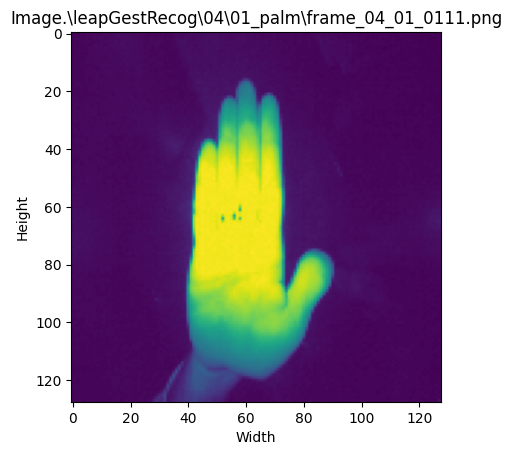

In [9]:
plot_image(imagepaths[8110])

converting image to numerical data

In [4]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv.imread(path) # Reads image and returns np.array
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv.resize(img, (128,128))
  X.append(img)
  
  # Processing label in image path
  category = path.split("\\")[-2]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 128, 128, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  40000
Labels loaded:  40000
1 .\leapGestRecog\00\01_palm\frame_00_01_0001.png


splitting the data into train and test set

In [5]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

importing the libaries for neural networks

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout

preparing the CNN

In [7]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)      

fitting the model and checking the accuarcy

In [8]:
history=model.fit(X_train, y_train, epochs=3, batch_size=64, verbose=1, validation_data=(X_test,y_test))

Epoch 1/3


438/438 [==============================] - 209s 470ms/step - loss: 0.4258 - accuracy: 0.9503 - val_loss: 0.0082 - val_accuracy: 0.9978
Epoch 2/3
438/438 [==============================] - 198s 453ms/step - loss: 0.0106 - accuracy: 0.9973 - val_loss: 0.0014 - val_accuracy: 0.9998
Epoch 3/3
438/438 [==============================] - 177s 405ms/step - loss: 0.0105 - accuracy: 0.9974 - val_loss: 0.0020 - val_accuracy: 0.9992


saving the model

In [9]:
model.save('handrecog_model.h5')

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


converting the model to ONNX

In [10]:
model = tf.keras.models.load_model(r"C:\Users\hp\Desktop\hand gesture\Hand_Gesture_Recog\handrecog_model.h5")
tf.saved_model.save(model, "tmp_model")

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


converting the model to ONNX

In [11]:
!python -m tf2onnx.convert --saved-model tmp_model --output "handrecognition_model.onnx"

2023-11-24 11:09:52.929555: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2023-11-24 11:10:00.641240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 11:10:00,643 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-11-24 11:10:01,063 - INFO - Signatures found in model: [serving_def

In [12]:
predictions = model.predict(X_test) # Make predictions towards the test set

375/375 [==============================] - 15s 39ms/step


In [13]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(5, 5)

In [14]:
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

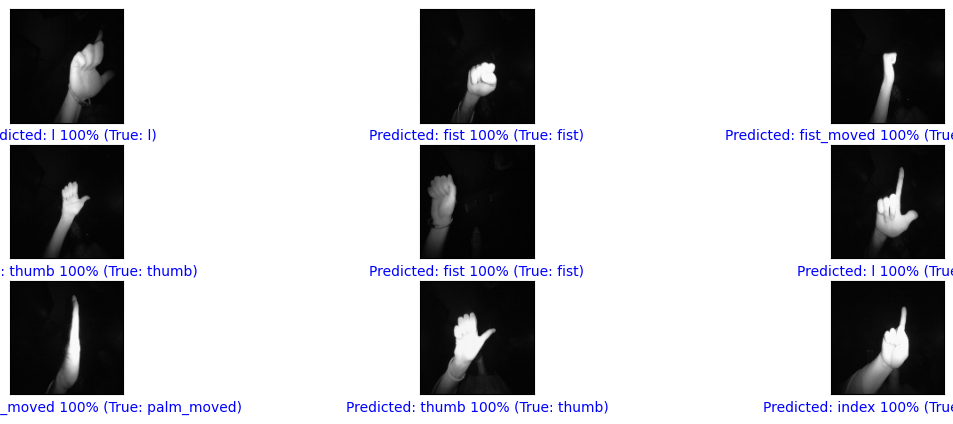

In [15]:
validate_9_images(predictions, y_test, X_test)

In [16]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [28]:
# H = Horizontal
# V = Vertical
df_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])
print(df_confusion_matrix)

                   Predicted Thumb Down  Predicted Palm (H)  Predicted L  \
Actual Thumb Down                  1199                   0            0   
Actual Palm (H)                       0                1195            0   
Actual L                              0                   0         1228   
Actual Fist (H)                       0                   0            0   
Actual Fist (V)                       0                   0            0   
Actual Thumbs up                      4                   0            0   
Actual Index                          0                   0            0   
Actual OK                             0                   0            0   
Actual Palm (V)                       0                   0            0   
Actual C                              0                   0            0   

                   Predicted Fist (H)  Predicted Fist (V)  \
Actual Thumb Down                   0                   0   
Actual Palm (H)                     0    

In [18]:
print(df_confusion_matrix)

                   Predicted Thumb Down  Predicted Palm (H)  Predicted L  \
Actual Thumb Down                  1199                   0            0   
Actual Palm (H)                       0                1195            0   
Actual L                              0                   0         1228   
Actual Fist (H)                       0                   0            0   
Actual Fist (V)                       0                   0            0   
Actual Thumbs up                      4                   0            0   
Actual Index                          0                   0            0   
Actual OK                             0                   0            0   
Actual Palm (V)                       0                   0            0   
Actual C                              0                   0            0   

                   Predicted Fist (H)  Predicted Fist (V)  \
Actual Thumb Down                   0                   0   
Actual Palm (H)                     0    

In [29]:
f1_scores = {}

# Calculate F1 score for each class
for i in range(df_confusion_matrix.shape[0]):
    true_positives = df_confusion_matrix.iloc[i, i]
    false_positives = df_confusion_matrix.iloc[i, :].sum() - true_positives
    false_negatives = df_confusion_matrix.iloc[:, i].sum() - true_positives
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores[df_confusion_matrix.index[i]] = f1

print(f1_scores)

{'Actual Thumb Down': 0.9983347210657786, 'Actual Palm (H)': 0.9974958263772955, 'Actual L': 1.0, 'Actual Fist (H)': 1.0, 'Actual Fist (V)': 1.0, 'Actual Thumbs up': 0.9983646770237121, 'Actual Index': 0.9975328947368421, 'Actual OK': 1.0, 'Actual Palm (V)': 1.0, 'Actual C': 1.0}


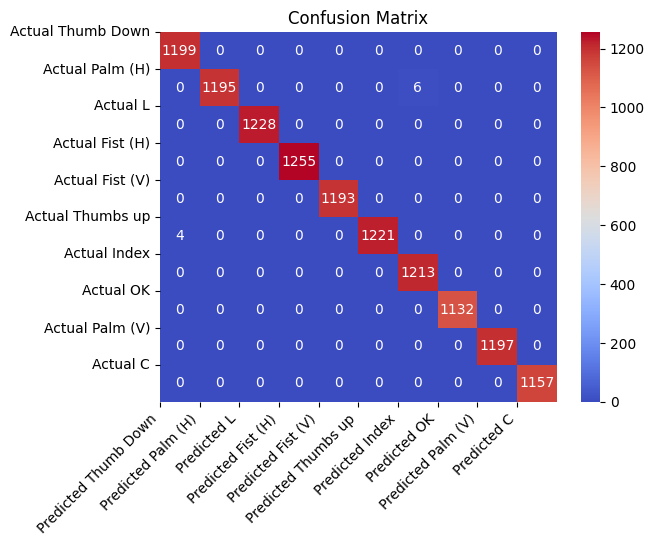

In [34]:
import seaborn as sns

fig, ax = plt.subplots()
sns.heatmap(df_confusion_matrix, annot=True, cmap='coolwarm', fmt='d', ax=ax)

# Add labels and title
ax.set_xticks(range(len(df_confusion_matrix.columns)))
ax.set_yticks(range(len(df_confusion_matrix.index)))
ax.set_xticklabels(df_confusion_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(df_confusion_matrix.index)
ax.set_title('Confusion Matrix')

# Show the graph
plt.show()